## Exploratory Data Analysis (EDA) — ArtEmis Annotations

This notebook performs an exploratory analysis of the ArtEmis annotations dataset.
We want to understand:

- Distribution of art styles in the dataset  
- How many captions per artwork  
- Length statistics of captions  
- Most common words  
- Emotion distribution  
- Whether some art styles/painters correlate with specific emotions  
- Caption diversity (unique words, vocabulary richness)
- Common bigrams which would influence prob. of them occuring together during prediction

This analysis helps in understanding:
- How difficult captioning will be  
- How large our vocabulary needs to be
- Whether sequences require truncation  
- How balanced the emotion categories are (important for emotional captioning)


In [3]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 

CSV_PATH = "artemis_dataset_release_v0.csv"  # update path if needed
df = pd.read_csv(CSV_PATH)

df.head()

,art_style,painting,emotion,utterance,repetition
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10


## Basic Structure of the Dataset

We inspect:
- Number of rows (annotations)
- Column types
- Missing values
- Example annotations


In [14]:
print("Number of rows:", len(df))
print("\nColumn information:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())


Number of rows: 454684

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454684 entries, 0 to 454683
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   art_style   454684 non-null  object
 1   painting    454684 non-null  object
 2   emotion     454684 non-null  object
 3   utterance   454684 non-null  object
 4   repetition  454684 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 17.3+ MB

Missing values:
art_style     0
painting      0
emotion       0
utterance     0
repetition    0
dtype: int64


## Annotations per Artwork

Each painting in ArtEmis typically has 5–6 captions, but some have 40+. We confirm this distribution.


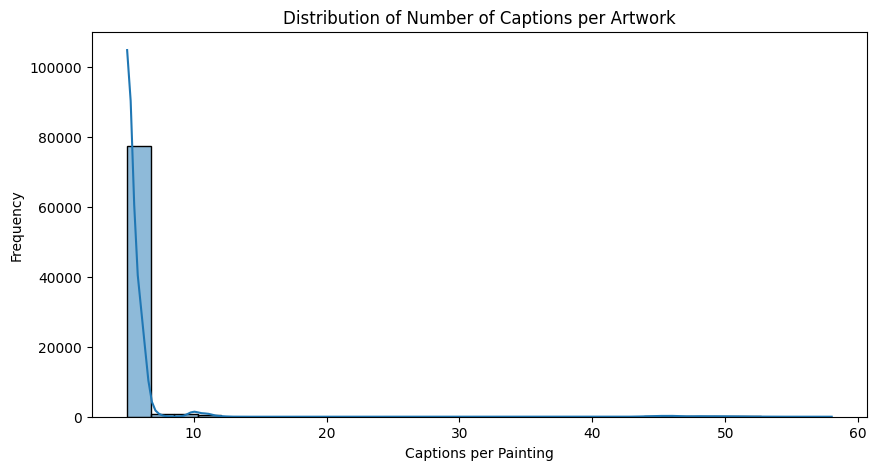

count    80031.000000
mean         5.681348
std          4.025648
min          5.000000
25%          5.000000
50%          5.000000
75%          5.000000
max         58.000000
dtype: float64

In [4]:
import seaborn as sns

counts = df.groupby(["art_style", "painting"]).size()

plt.figure(figsize=(10,5))
sns.histplot(counts, bins=30, kde=True)
plt.title("Distribution of Number of Captions per Artwork")
plt.xlabel("Captions per Painting")
plt.ylabel("Frequency")
plt.show()

counts.describe()


## Emotion Labels

ArtEmis contains 9 emotion categories selected by annotators.
We examine the balance of these emotions.


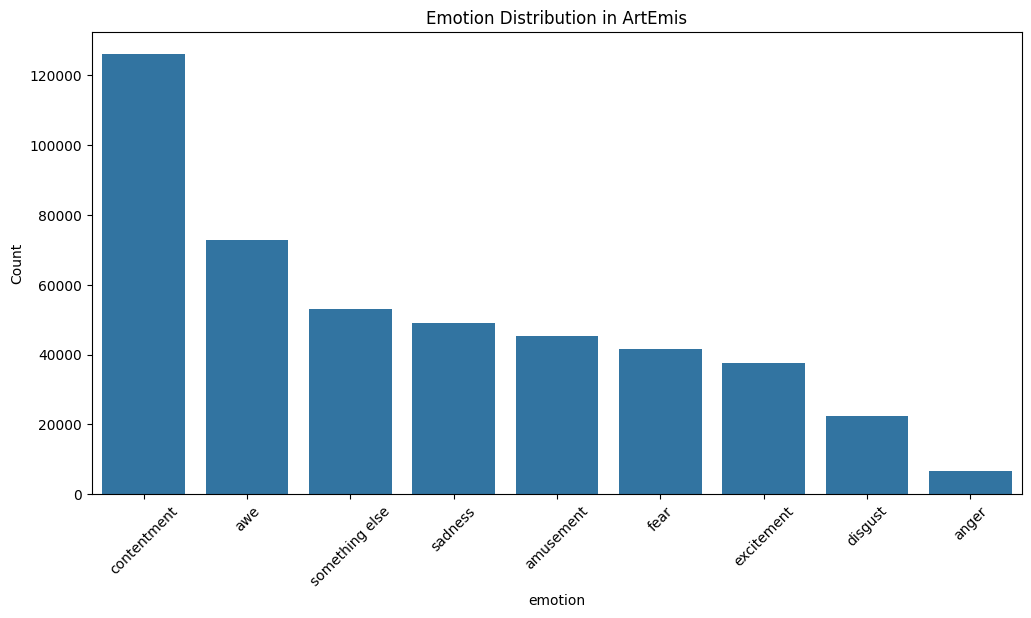

emotion
contentment       126134
awe                72927
something else     52962
sadness            49061
amusement          45336
fear               41577
excitement         37636
disgust            22411
anger               6640
Name: count, dtype: int64

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Emotion Distribution in ArtEmis")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

df["emotion"].value_counts()


### Art Styles
Check whether the dataset is balanced across artistic genres.

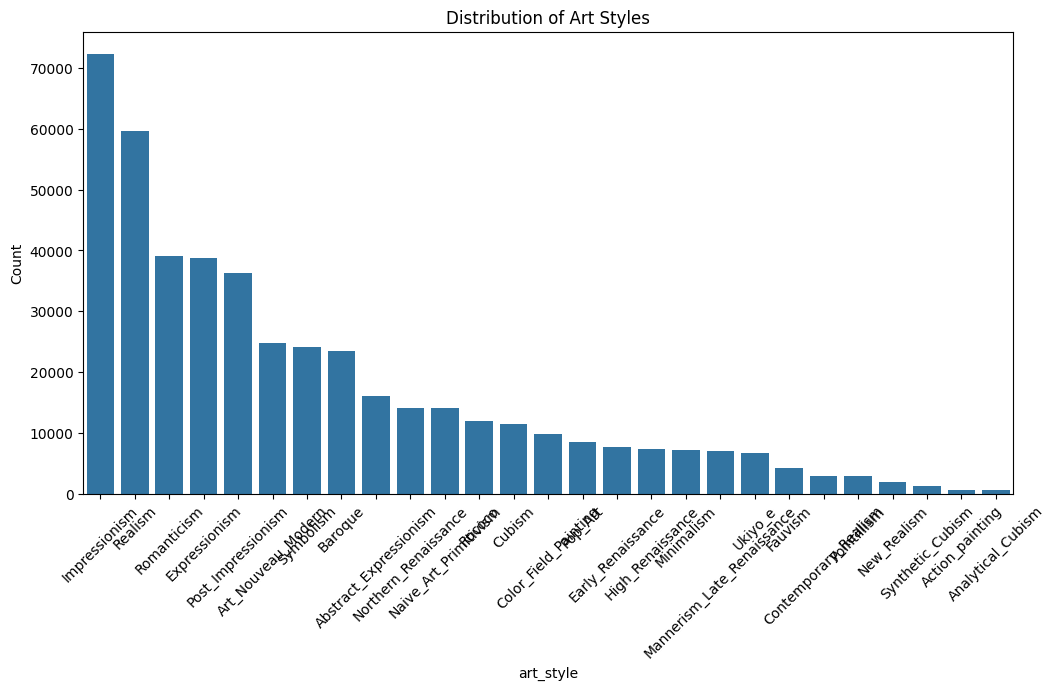

art_style
Impressionism                 72361
Realism                       59681
Romanticism                   39069
Expressionism                 38717
Post_Impressionism            36374
Art_Nouveau_Modern            24711
Symbolism                     24103
Baroque                       23469
Abstract_Expressionism        16075
Northern_Renaissance          14160
Naive_Art_Primitivism         14086
Rococo                        11904
Cubism                        11462
Color_Field_Painting           9836
Pop_Art                        8438
Early_Renaissance              7622
High_Renaissance               7366
Minimalism                     7163
Mannerism_Late_Renaissance     7047
Ukiyo_e                        6615
Fauvism                        4191
Contemporary_Realism           2953
Pointillism                    2870
New_Realism                    1848
Synthetic_Cubism               1284
Action_painting                 664
Analytical_Cubism               615
Name: count, dtype

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="art_style", order=df["art_style"].value_counts().index)
plt.title("Distribution of Art Styles")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

df["art_style"].value_counts()


## Caption Length Analysis

Caption length (in tokens) impacts:
- LSTM sequence length
- Transformer max sequence length
- Padding / truncation decisions


In [ ]:
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

df["tokens"] = df["utterance"].astype(str).apply(simple_tokenize) #This gives a list of the words that make up the utterance for a particular annotation
df["length"] = df["tokens"].apply(len) #Total number of words in the utterance 


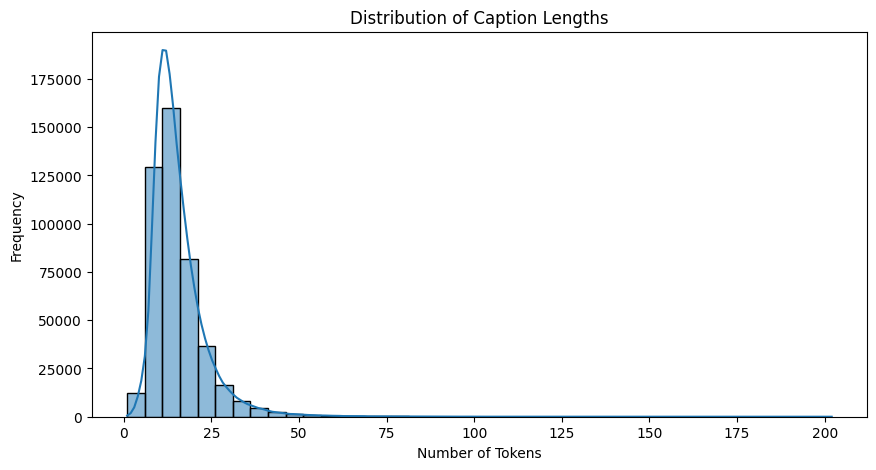

count    454684.000000
mean         15.669509
std           7.933006
min           1.000000
50%          14.000000
75%          18.000000
90%          25.000000
95%          30.000000
99%          44.000000
max         202.000000
Name: length, dtype: float64

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df["length"], bins=40, kde=True)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

df["length"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

### Observations:
- The mean caption length is usually around 15 words. 
- 95% of captions fall under ~30 tokens.
- This justifies the use of `MAX_LEN = 30` in preprocessing.


### Most Common Words and Most common descriptors 

This helps in:
- Vocabulary building - frequency distribution allows us to make an estimate for good vocabulary. 
- Understanding caption themes
- Checking for stopwords


In [40]:
all_words = [w for tokens in df["tokens"] for w in tokens]
counter = Counter(all_words)
common_words = counter.most_common(50)

exclude_certain_words = all_words

common_words


[('the', 660157),
 ('and', 257454),
 ('a', 238508),
 ('of', 210631),
 ('is', 180436),
 ('to', 134277),
 ('in', 126483),
 ('like', 119114),
 ('this', 118255),
 ('i', 97112),
 ('it', 93980),
 ('looks', 91427),
 ('me', 76573),
 ('are', 70959),
 ('on', 63827),
 ('with', 58486),
 ('painting', 49095),
 ('colors', 47898),
 ('look', 47630),
 ('feel', 45939),
 ('makes', 45699),
 ('very', 45596),
 ('that', 41203),
 ('be', 37420),
 ('her', 37366),
 ('man', 33792),
 ('at', 33649),
 ('as', 31742),
 ('woman', 31689),
 ('for', 27881),
 ('but', 27809),
 ('its', 25695),
 ('so', 24885),
 ('his', 24741),
 ('an', 24010),
 ('people', 23211),
 ('she', 23155),
 ('has', 22606),
 ('seems', 22397),
 ('make', 22348),
 ('they', 22151),
 ('face', 21749),
 ('dark', 20390),
 ('he', 20245),
 ('not', 19835),
 ('what', 19057),
 ('there', 18812),
 ('or', 18488),
 ('scene', 18248),
 ('out', 17530)]

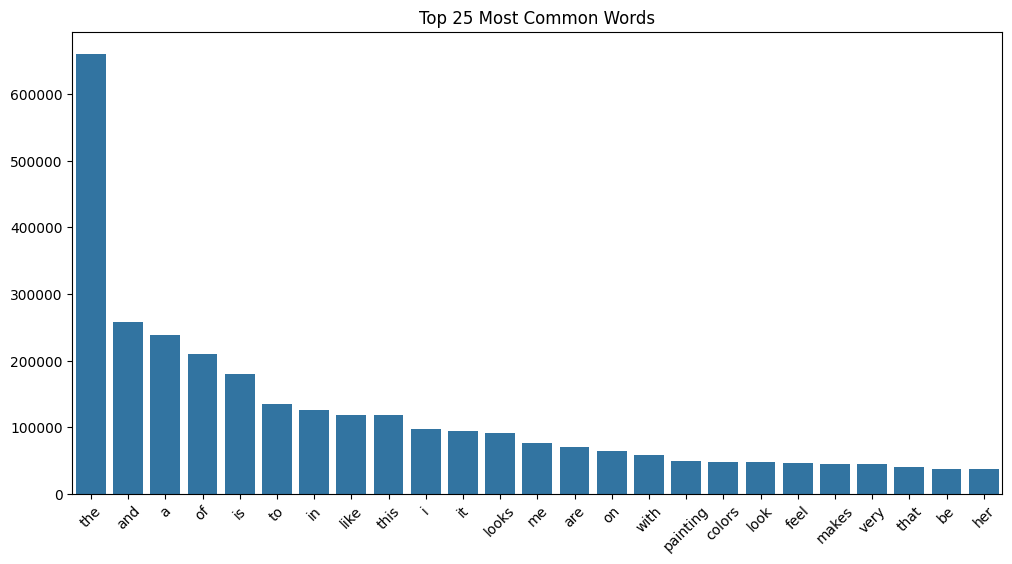

In [10]:
words, freqs = zip(*common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=45)
plt.title("Top 25 Most Common Words")
plt.show()


### Vocabulary Size

We compute:
- Total unique words - this informs whether our vocabulary size is large enough to account for certain unique descriptors that are needed to adequately describe a painting.
Given that there are ~57k unique words, we can evaluate the impact of choosing the top 8k unique words by frequency. 
- Frequency cutoff impact (for vocab limit)

In [11]:
vocab_size = len(counter)
vocab_size

57981

In [12]:
print("Vocabulary size (no limit):", vocab_size)

freq_counts = pd.DataFrame(counter.values(), columns=["freq"])
freq_counts.describe()

Vocabulary size (no limit): 57981


,freq
count,57981.000000
mean,122.879478
std,3692.451257
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,660157.000000


### Emotion vs Caption Length

Check if emotional explanations tend to be longer or shorter. 
We see that the median caption length across all the emotions are similar as are the quartile ranges.

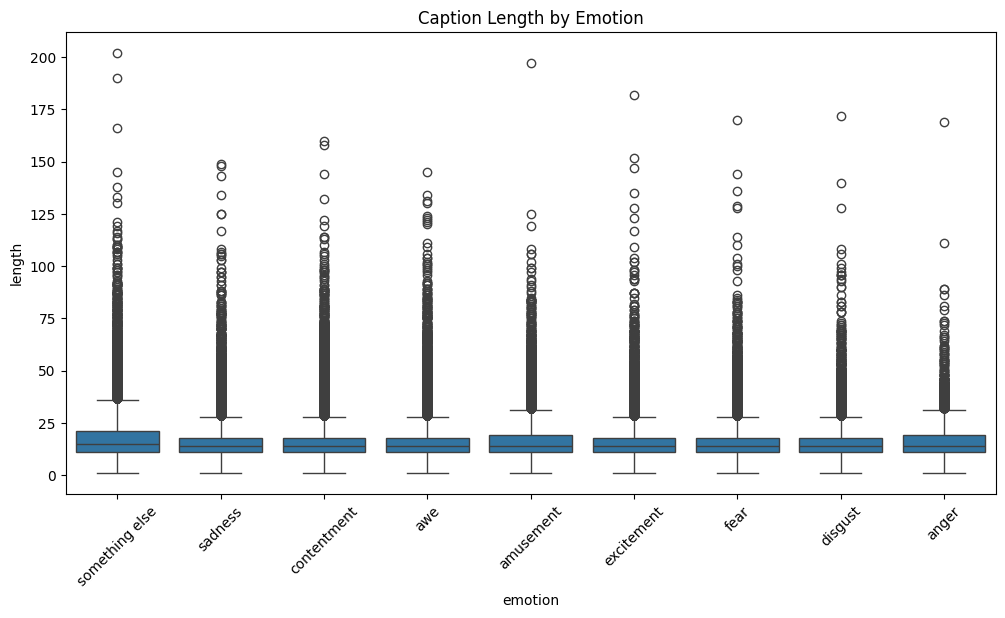

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="emotion", y="length")
plt.xticks(rotation=45)
plt.title("Caption Length by Emotion")
plt.show()

### Emotion vs Art Style

Do certain art styles evoke specific emotions in general? Here we are considering for a particluar art style, the % split with which they are distrbuted across the emotions. We can expect to see a large % in contentment for most art styles because it is the most frequently occuring overall.

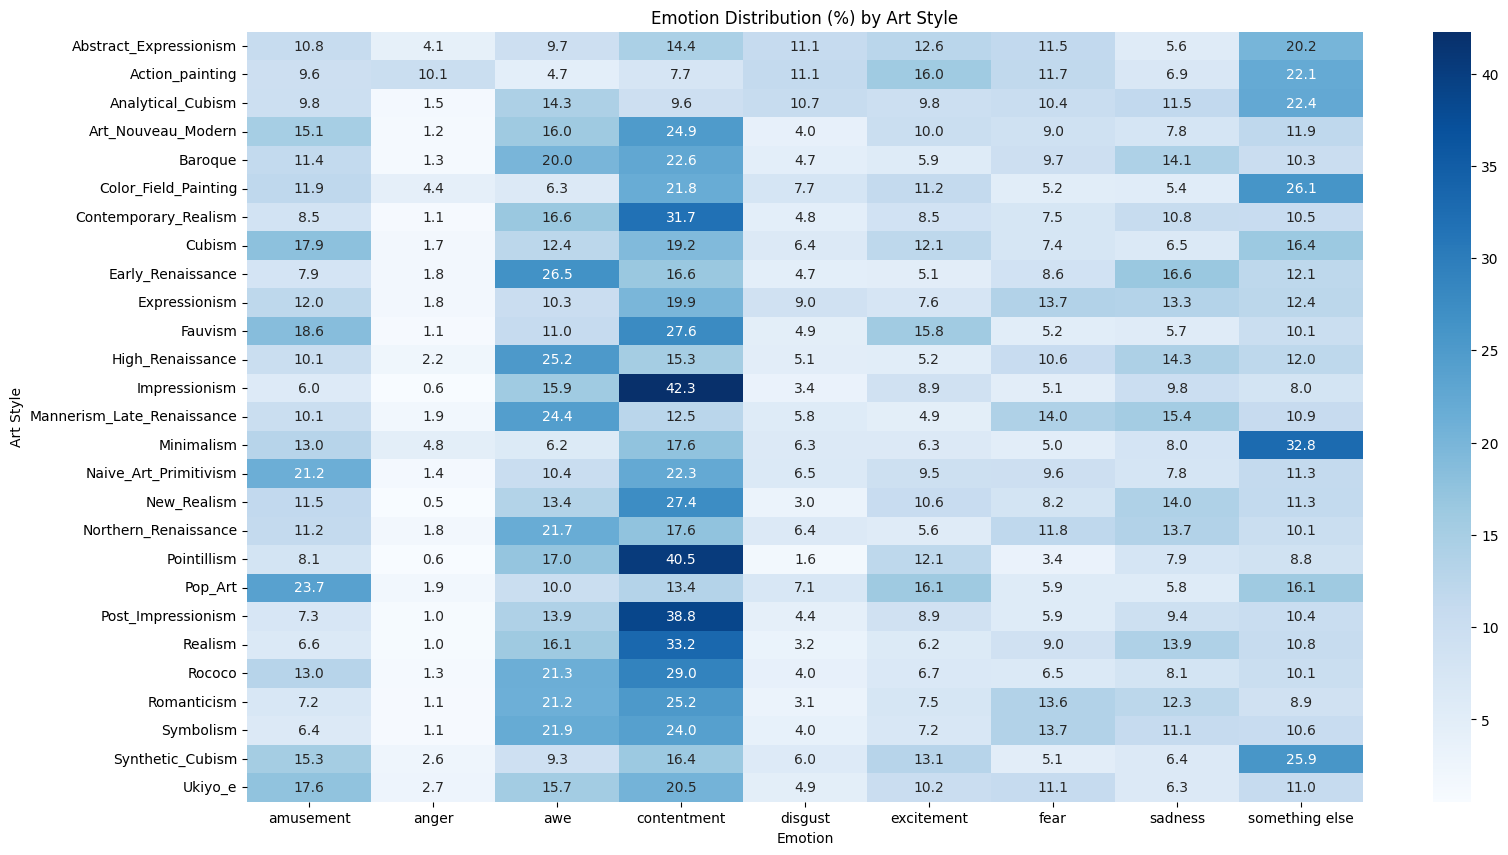

In [18]:
pivot = pd.crosstab(df["art_style"], df["emotion"])

# Normalize per art style (row-wise)
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0) * 100

plt.figure(figsize=(18,10))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="Blues")
plt.title("Emotion Distribution (%) by Art Style")
plt.xlabel("Emotion")
plt.ylabel("Art Style")
plt.show()



### Emotion Vs. Painter 

Do paintings produced by a certain painter tend to evoke similar emotions? 

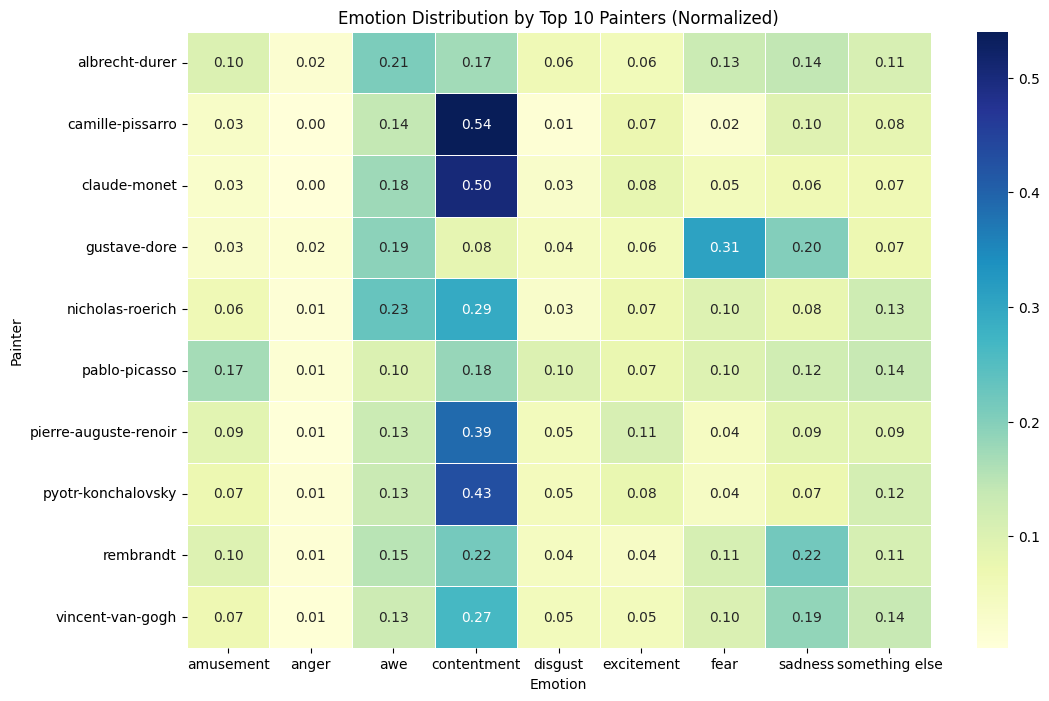

In [13]:
top_painters = df['painting'].apply(lambda x: x.split('_')[0]).value_counts().head(10).index
painter_emotion_df = df[df['painting'].apply(lambda x: x.split('_')[0]).isin(top_painters)].copy()
painter_emotion_df['painter_name'] = painter_emotion_df['painting'].apply(lambda x: x.split('_')[0])

# Create a Cross-Tabulation (Confusion Matrix style)
ct = pd.crosstab(painter_emotion_df['painter_name'], painter_emotion_df['emotion'])

# Normalize by row (so we see percentages per painter, not raw counts)
ct_norm = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(ct_norm, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=.5)
plt.title('Emotion Distribution by Top 10 Painters (Normalized)')
plt.ylabel('Painter')
plt.xlabel('Emotion')
plt.show()

### Caption Diversity for Each Painting

We can measure how varied captions are for the same image. This is relevant because emotional captioning depends on diversity.

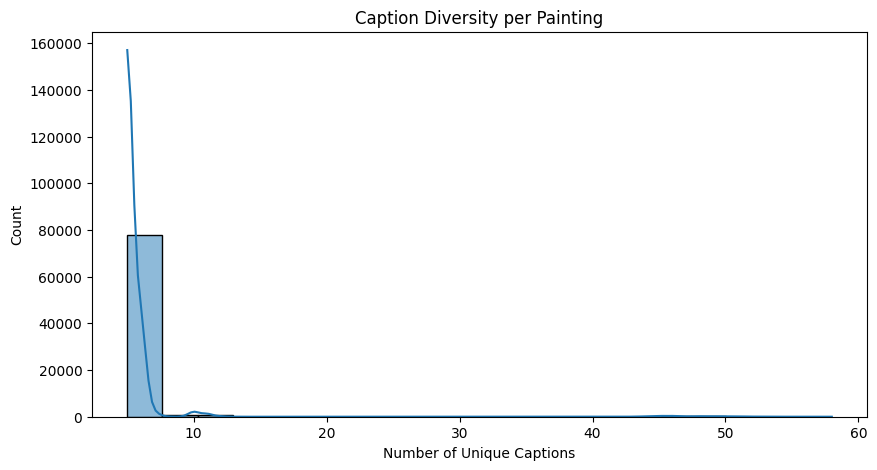

count    80031.000000
mean         5.681024
std          4.025027
min          5.000000
25%          5.000000
50%          5.000000
75%          5.000000
max         58.000000
Name: tokens, dtype: float64

In [ ]:
diversity = (
    df.groupby(["art_style","painting"])["tokens"].apply(lambda lst: len(set(tuple(t) for t in lst)))
)

plt.figure(figsize=(10,5))
sns.histplot(diversity, bins=20, kde=True)
plt.title("Caption Diversity per Painting")
plt.xlabel("Number of Unique Captions")
plt.show()

diversity.describe()


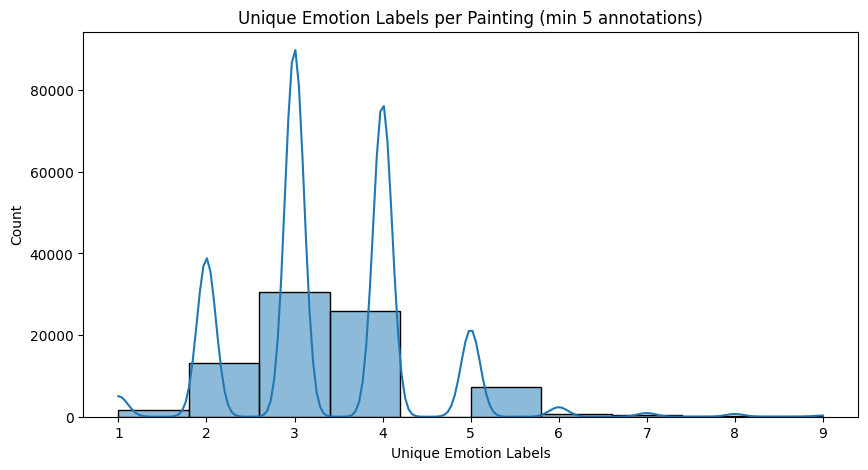

count    80031.000000
mean         3.364834
std          1.032495
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: emotion, dtype: float64

In [20]:
MIN_ANNOTATIONS = 5  # adjust threshold here

counts_per_painting = df.groupby(["art_style", "painting"]).size()

valid_paintings = counts_per_painting[counts_per_painting >= MIN_ANNOTATIONS].index

df_filtered = df.set_index(["art_style", "painting"]).loc[valid_paintings].reset_index()

emo_per_painting = (
    df_filtered.groupby(["art_style","painting"])["emotion"]
    .nunique()
)

plt.figure(figsize=(10,5))
sns.histplot(emo_per_painting, bins=10, kde=True)
plt.title(f"Unique Emotion Labels per Painting (min {MIN_ANNOTATIONS} annotations)")
plt.xlabel("Unique Emotion Labels")
plt.ylabel("Count")
plt.show()

emo_per_painting.describe()


We see that for paintings that have >5 annotations, on average they have ~3 unique emotions that have been ascribed to them. 
This means that the emotions for paintings are fairly subjective.

### Painting and Annotation

Here we can view a sample of 5 images along with the annotations that had been described for them. This allows us to view the range in captioning and emotions for the same image more clearly. 

Merged rows (valid images with captions): 16833

[1] pointillism — henri-martin_terrace-of-the-manor-in-marquayrol
Path: C:\Users\91887\Documents\ArtEmis\Img3k\Pointillism\henri-martin_terrace-of-the-manor-in-marquayrol.jpg


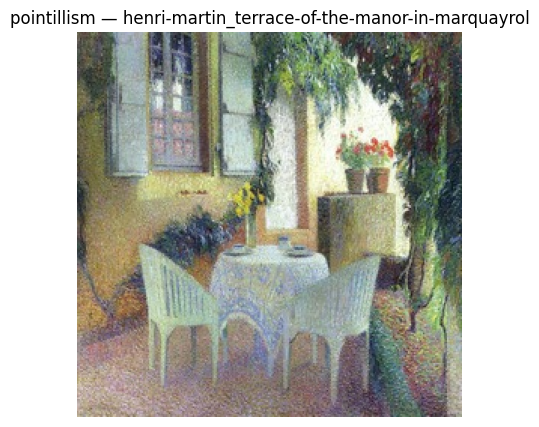

    emotion                                                                                                     utterance
contentment                                                          The simplicity of the white is enjoyable to look at.
contentment                                                The scene looks so welcome and inviting and soft and feminine.
contentment                                                             the way the light is depicted hitting the flowers
contentment                                                      I feel very calmed looking at this warmly colored scene.
contentment the outdoor eating space is contenting and the graininess of the picture is soothing because it feels vintage
contentment                                    Breezy Saturday morning out on the patio as the sun comes up. Quite comfy.

[2] synthetic_cubism — pablo-picasso_still-life-with-violin-and-fruits-1912
Path: C:\Users\91887\Documents\ArtEmis\Img3k\Synthetic_Cubism\pablo-p

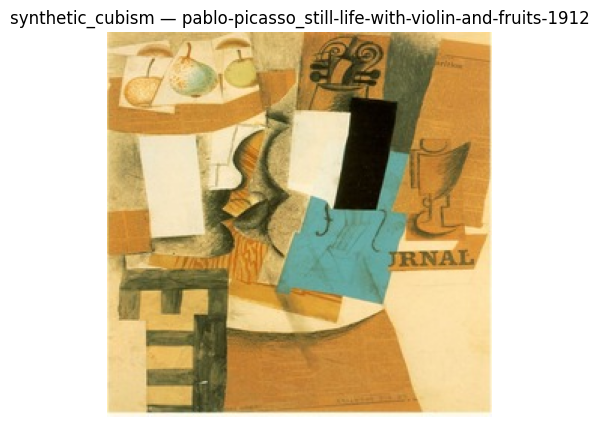

       emotion                                                                                     utterance
           awe                                     The use of blue is wonderfully executed within the frame.
something else                                                  confused at the overall lack of organization
   contentment                                            The beautiful color choice is soothing to the eye.
   contentment                                                 color palette seems very neutral and relaxing
    excitement The images of instruments and fruits makes me think about art, and gets my imagination going.
something else                                         This is a weird collage of potentially related items?

[3] rococo — bernardo-bellotto_church-of-the-holy-sacrament-in-the-new-town-1778
Path: C:\Users\91887\Documents\ArtEmis\Img3k\Rococo\bernardo-bellotto_church-of-the-holy-sacrament-in-the-new-town-1778.jpg


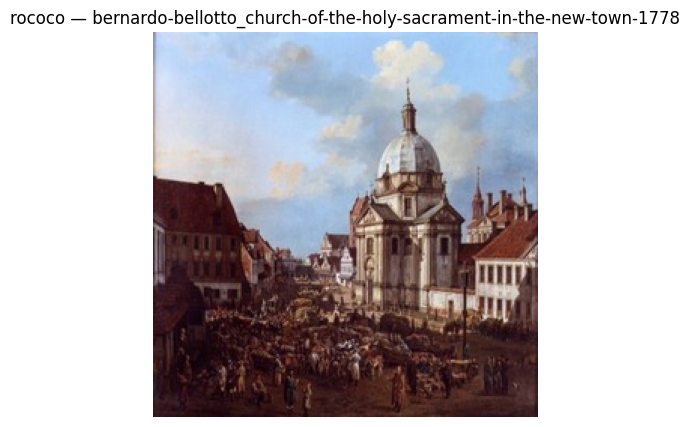

    emotion                                                                          utterance
 excitement                         This appears to be a busy marketplace with a lot going on.
        awe     The details in this painting is beautiful. Captures all the people down below.
contentment                                        The incredible use of blue reinforces hope.
 excitement The city streets are bustling with people and energy. There's a lot going on here.
        awe                                 the grandeur of the architecture in the background

[4] analytical_cubism — pablo-picasso_clarinet-1911
Path: C:\Users\91887\Documents\ArtEmis\Img3k\Analytical_Cubism\pablo-picasso_clarinet-1911.jpg


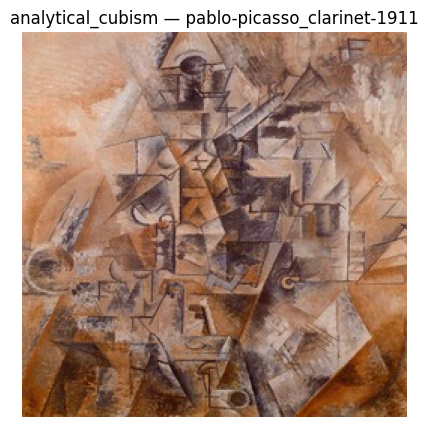

       emotion                                                                                                         utterance
       disgust                                        The angles are very harsh and sharp and the coloration is muddy and ashen.
          fear                                                                                  Very overwhelming and confusing.
          fear                                        Something about the sunglasses and sharp angles is just really unsettling.
something else                                   It makes me feel logical because of all the sharp edges and geometrical shapes.
           awe This is a powerful image. The straight lines and the planes indicate strength to me, and the palette is vigorous.

[5] post_impressionism — vladimir-dimitrov_unknown-title-8
Path: C:\Users\91887\Documents\ArtEmis\Img3k\Post_Impressionism\vladimir-dimitrov_unknown-title-8.jpg


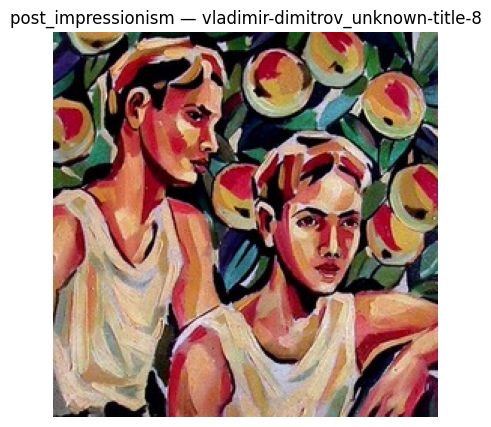

       emotion                                                                                                        utterance
           awe                 The colors used are absolutely gorgeous and I appreciate the noble eyes the figures seem to own.
something else The color is used are so similar that it’s hard to distinguish the background from the main focus of the picture
           awe                  The intensity in the young mens eyes and the warm/cool contrasting hues creates a strong energy
     amusement                                              It looks like the boys have crowns made of hot dogs on their heads.
    excitement                                                              The art style and the color palette make me excited


In [35]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------------------
# ABSOLUTE path to your Img3k folder
# -----------------------------------------
IMG_ROOT = r"C:\Users\91887\Documents\ArtEmis\Img3k"

# -----------------------------------------
# Load annotations
# -----------------------------------------
df = pd.read_csv("artemis_dataset_release_v0.csv")   # update if needed

# -----------------------------------------
# Build table of actual existing images
# -----------------------------------------
existing_images = []

for art_style in os.listdir(IMG_ROOT):
    style_dir = os.path.join(IMG_ROOT, art_style)
    if not os.path.isdir(style_dir):
        continue

    for file in os.listdir(style_dir):
        name, ext = os.path.splitext(file)
        if ext.lower() in [".jpg", ".jpeg", ".png"]:
            existing_images.append({
                "art_style": art_style.lower(),
                "painting": name.lower(),
                "filepath": os.path.join(style_dir, file)
            })

existing_df = pd.DataFrame(existing_images)

# -----------------------------------------
# Clean annotation columns to lowercase to match
# -----------------------------------------
df["art_style_clean"] = df["art_style"].str.lower()
df["painting_clean"]  = df["painting"].str.lower()

# -----------------------------------------
# Merge annotations with actual existing images
# -----------------------------------------
merged = df.merge(
    existing_df,
    left_on=["art_style_clean", "painting_clean"],
    right_on=["art_style", "painting"],
    how="inner"
)

print("Merged rows (valid images with captions):", len(merged))

# -----------------------------------------
# Sample 5 existing paintings SAFELY
# -----------------------------------------
sampled_paintings = merged.groupby(
    ["art_style_clean", "painting_clean", "filepath"]
).size().sample(5, random_state=45).reset_index()

# -----------------------------------------
# Display 5 images + their annotations
# -----------------------------------------
for idx, row in sampled_paintings.iterrows():
    style = row["art_style_clean"]
    painting = row["painting_clean"]
    path = row["filepath"]

    print(f"\n[{idx+1}] {style} — {painting}")
    print("Path:", path)

    # Display the image
    img = Image.open(path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{style} — {painting}")
    plt.show()

    # Show annotations for this painting
    subset = merged[
        (merged["art_style_clean"] == style) &
        (merged["painting_clean"] == painting)
    ][["emotion", "utterance"]]

    print(subset.to_string(index=False))


### Bigrams and Trigrams 
Showcases which words are most likely to occur together, model is likely to over train on these and hence we need to be vigilant 

In [4]:
from collections import Counter
import re

# --- Clean & tokenize function (simple) ---
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

# Apply tokenization
df["tokens_clean"] = df["utterance"].astype(str).apply(simple_tokenize)

# --- Extract bigrams ---
bigrams = []
for tokens in df["tokens_clean"]:
    for i in range(len(tokens) - 1):
        bigrams.append((tokens[i], tokens[i+1]))

# Count bigrams
bigram_counts = Counter(bigrams)
common_bigrams = bigram_counts.most_common(25)

common_bigrams[:10]  # show the top 10


[(('of', 'the'), 61193),
 (('in', 'the'), 52036),
 (('looks', 'like'), 49748),
 (('and', 'the'), 40570),
 (('makes', 'me'), 29803),
 (('like', 'a'), 29736),
 (('on', 'the'), 29197),
 (('to', 'be'), 26052),
 (('of', 'a'), 21919),
 (('me', 'feel'), 20247)]

C:\Users\91887\AppData\Local\Temp\ipykernel_34880\4264113837.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x="count", y="bigram_str", palette="Blues_r")


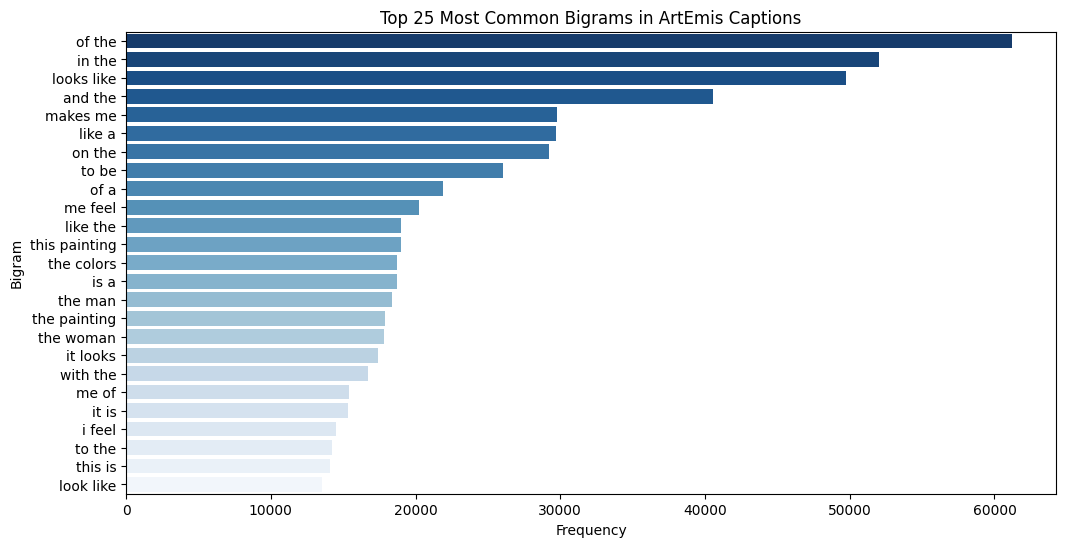

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame for plotting
bigram_df = pd.DataFrame(common_bigrams, columns=["bigram", "count"])
bigram_df["bigram_str"] = bigram_df["bigram"].apply(lambda x: " ".join(x))

plt.figure(figsize=(12,6))
sns.barplot(data=bigram_df, x="count", y="bigram_str", palette="Blues_r")
plt.title("Top 25 Most Common Bigrams in ArtEmis Captions")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()


In [10]:
import os 
CSV_PATH = r"C:\Users\91887\Documents\ArtEmis\artemis_dataset_release_v0.csv"
IMG_ROOT = r"C:\Img10k"

# Load Data
df = pd.read_csv(CSV_PATH)

# Basic Filtering to match your training subset logic
# (Optional: If you want to analyze ONLY the 10k subset, you need to filter by the images present in C:\Img10k)
# For now, let's analyze the full CSV to see the "big picture" or filter if needed.
# Let's assume we filter to match the training set for consistency.
image_files = set()
for root, dirs, files in os.walk(IMG_ROOT):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.add(file.rsplit('.', 1)[0].lower()) # Store filename without extension

# Create a key to match CSV
df['filename_key'] = df['painting'].astype(str).str.lower()
subset_df = df[df['filename_key'].isin(image_files)].copy()

print(f"Original CSV Size: {len(df)}")
print(f"Subset (10k images) Size: {len(subset_df)}")


Original CSV Size: 454684
Subset (10k images) Size: 58361


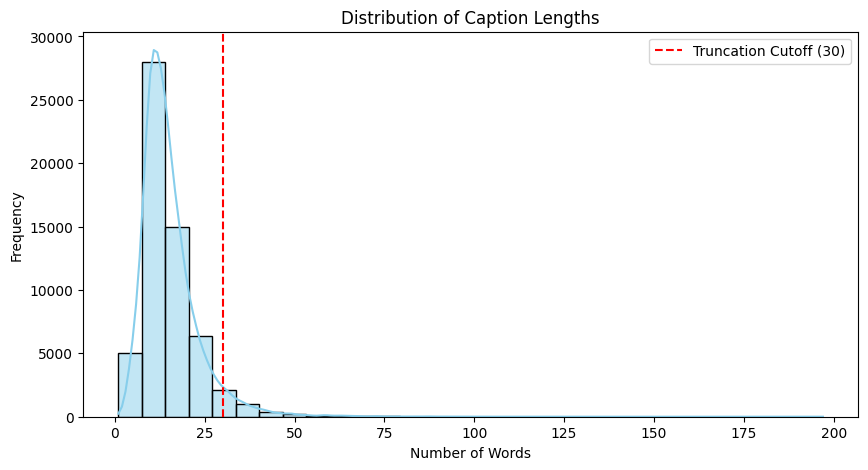

Mean Caption Length: 15.32
Max Caption Length: 197


In [8]:
subset_df['caption_len'] = subset_df['utterance'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(subset_df['caption_len'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=30, color='r', linestyle='--', label='Truncation Cutoff (30)')
plt.legend()
plt.show()

print(f"Mean Caption Length: {subset_df['caption_len'].mean():.2f}")
print(f"Max Caption Length: {subset_df['caption_len'].max()}")